In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df = pd.read_csv('/content/drive/My Drive/Dataset/jena_climate_2009_2016/jena_climate_2009_2016.csv')

print(df.isnull().sum())
df.head()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [3]:
# membuat data menjadi per jam.
df = df[5::6]
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [4]:
df_rho = df[['Date Time', 'rho (g/m**3)']]
df_rho

,Date Time,rho (g/m**3)
5,01.01.2009 01:00:00,1307.86
11,01.01.2009 02:00:00,1312.25
17,01.01.2009 03:00:00,1312.18
23,01.01.2009 04:00:00,1313.61
29,01.01.2009 05:00:00,1317.19
...,...,...
420521,31.12.2016 19:10:00,1280.70
420527,31.12.2016 20:10:00,1281.87
420533,31.12.2016 21:10:00,1288.02
420539,31.12.2016 22:10:00,1288.03


In [5]:
df_rho.describe()

,rho (g/m**3)
count,70091.000000
mean,1216.061232
std,39.974263
min,1059.450000
25%,1187.470000
50%,1213.800000
75%,1242.765000
max,1393.540000


In [6]:
# Mencari nilai 10% skala data dari kolom rho (g/m**3)

max_rho = df_rho['rho (g/m**3)'].max()
min_rho = df_rho['rho (g/m**3)'].min()


diff_rho = max_rho - min_rho

max_MAE = diff_rho*0.1

print('Nilai maksimal rho (g/m**3) : ', max_rho, '\nNilai minimal rho (g/m**3) : ', min_rho)
print('Nilai maksimal MAE (10% dari skala data (rho (g/m**3))): ',max_MAE,)

Nilai maksimal rho (g/m**3) :  1393.54 
Nilai minimal rho (g/m**3) :  1059.45
Nilai maksimal MAE (10% dari skala data (rho (g/m**3))):  33.40899999999999


In [7]:
# Membagi data train (80%) data data validation (20%)

jml_data = len(df_rho)

rho_train = df_rho[0:int(jml_data*0.8)]
rho_val = df_rho[int(jml_data*0.8):]

print('Total data : ',jml_data)
print('Jumlah data train : ',len(rho_train))
print('Jumlah data validasi : ',len(rho_val))

Total data :  70091
Jumlah data train :  56072
Jumlah data validasi :  14019


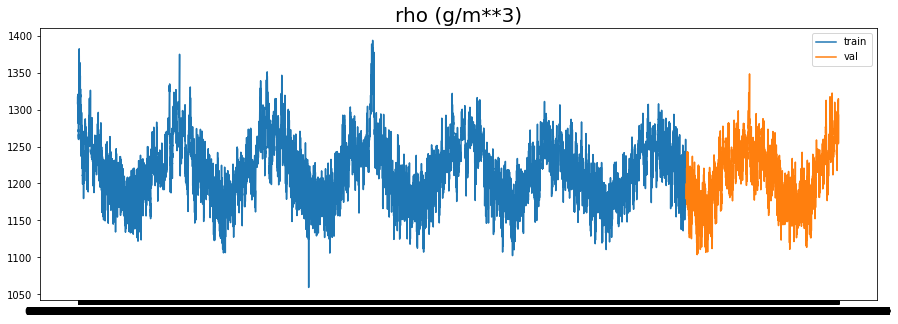

In [8]:
# Plotting data train dan data validation

dates_train = rho_train['Date Time'].values
dates_val = rho_val['Date Time'].values

df_rho_train = rho_train['rho (g/m**3)'].values
df_rho_val = rho_val['rho (g/m**3)'].values

plt.figure(figsize=(15,5))

ax1 = plt.plot(dates_train,df_rho_train)
ax2 = plt.plot(dates_val,df_rho_val)

plt.title('rho (g/m**3)', fontsize=20)
plt.legend(['train', 'val'], loc='upper right')

plt.show(ax1)
plt.show(ax2)

In [9]:
# Merubah data menjadi format yang dapat diterima oleh model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
# Menambah fungsi callback saat train data

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<max_MAE):
      print("\nMAE telah mencapai < 10% skala data!")
      self.model.stop_training = True
callbacks = myCallback()

In [11]:
# Membuat model

train_set = windowed_dataset(df_rho_train, window_size=24, batch_size=64, shuffle_buffer=1000)
val_set = windowed_dataset(df_rho_train, window_size=24, batch_size=64, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(100, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [12]:
# train data

optimizer = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.95)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=10, validation_data=val_set, callbacks=[callbacks])

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

876/876 [==============================] - 26s 29ms/step - loss: 364.8094 - mae: 365.3065 - val_loss: 31.9595 - val_mae: 32.4565
Epoch 2/10
873/876 [============================>.] - ETA: 0s - loss: 24.6273 - mae: 25.1226
MAE telah mencapai < 10% skala data!
876/876 [==============================] - 25s 29ms/step - loss: 24.6296 - mae: 25.1250 - val_loss: 32.7872 - val_mae: 33.2842


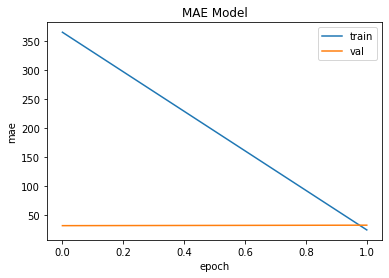

In [13]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

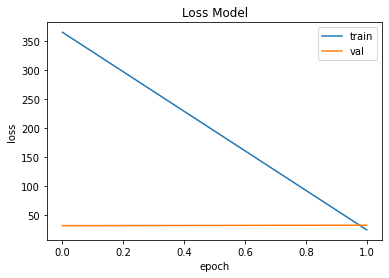

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()